In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from skimage.color import rgb2gray
from skimage import data
from skimage.util import random_noise
import math
import os
from skimage import io
from google.colab import drive

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=7044528069e3a19f5bca09dba6fe0a8e37763a42f2fc05c319fa8ba71647fbba
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 375.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB")
image = plt.imread("/content/drive/My Drive/Colab Notebooks/ALL DB/lena.png")

In [ ]:
image = rgb2gray(image)
plt.imshow(image)

NameError: ignored

In [ ]:
def dist(i, j, ic, jc):
    return math.sqrt(((i-ic)**2 + (j-jc)**2))

In [ ]:
    h = 512
    w = 512
    height = h+2    #new_height and width after padding
    width = w+2
    pi = 3.14
    m = 128
    
    r = height/2;
    outer_area = pi*r*r;

    Ua = outer_area/m

    rad = (int)(math.sqrt(Ua/pi))
    radius_list = []
    radius_list.append(rad)

    for i in range(1, m) :
        rad = (int)(math.sqrt((Ua + pi*rad*rad)/pi))
        radius_list.append(rad)
    #print(radius_list)
    
    ngroups = m
    Xc = height/2
    Yc = width/2   
    
    cols = []
    for i in range(0, m-1):  
        r1 = radius_list[i]
        r2 = radius_list[i+1]
        temp = []
        for j in range(0, height):
            for k in range(0, width):
                if dist(j, k, Xc, Yc) > r1 and dist(j, k, Xc, Yc) < r2:
                    temp.append((j,k))
        cols.append(temp)
        
    max_len = -1
    for i in range(len(cols)):
        max_len = max(max_len,len(cols[i]))
    
    for i in range(0, ngroups-1):
        cur_len = len(cols[i])
        for j in range(cur_len, max_len):
            cols[i].append(0)
            
    new_cols = []
    for i in range(0,len(cols)):
        new_cols.append(cols[i])

In [ ]:
def GFO(x):
  if x<0 :
    return -1*math.pow(-(2*x+x*x),0.5)
  else :
    return math.pow(-(2*x-x*x),0.5)

def fuzzy(image,i,j):
  norm = -100
  for k1 in range(i-1,i+2):
    for k2 in range(j-1,j+2):
      if(k1!=i and k2!=j):
        norm = max(norm,abs(image[i][j] - image[k1][k2]))

  sum = 0
  for k1 in range(i-1,i+2):
    for k2 in range(j-1,j+2):
      if(k1!=i and k2!=j):
        #cur between -1 and 1
        cur = (image[i][j] - image[k1][k2])/(norm+0.005)
        sum += -1*GFO(cur)
  sum *= 255
  sum += image[i][j]
  
  return sum
        



In [ ]:
def image_to_hash(image,h,w,new_cols):
    img = tf.image.resize_images(image,(h,w)) #resize image

    
    with tf.Session() as sess:
        img_s = sess.run(img)
        
    img_gray = rgb2gray(img_s)  #converting to gray scale
    paddings = tf.constant([[1, 1,], [1, 1]])  #up-down,left-right
    pad = tf.pad(img_gray,paddings,"CONSTANT")  #padding with zeros
    
    with tf.Session() as sess:
        img = sess.run(pad)
                     
                     
    pixels_cols = []

    for i in range(0,len(new_cols)):
        temp = []
        for j in range(0,len(new_cols[i])):
            if(new_cols[i][j]==0):
                temp.append(0)
                continue
            index_i = new_cols[i][j][0]
            index_j = new_cols[i][j][1]
            pixel = img[index_i][index_j]
            temp.append(pixel)
        pixels_cols.append(temp)
    
    pixels_cols = np.asarray(pixels_cols)
    #print(pixels_cols.shape)
    pixels_cols = np.transpose(pixels_cols)
    #print(pixels_cols.shape)
    
    avg_cols = []
    
    for i in range(0,len(pixels_cols)):
        mean = np.mean(np.asarray(pixels_cols[i]))
        avg_cols.append(mean)
        
        
    for i in range(0,len(pixels_cols)):
        for j in range(0,len(pixels_cols[i])):
            if(pixels_cols[i][j]>avg_cols[i]):
                pixels_cols[i][j] = 1
            else:
                pixels_cols[i][j] = 0
            
    hash1 = pixels_cols[0]
    for i in range(1,len(pixels_cols)):
        for j in range(0,len(pixels_cols[i])):
            hash1[j] += pixels_cols[i][j]

        
    avg_cols = np.mean(hash1)
    
    for i in range(len(hash1)):
        if(hash1[i]>avg_cols):
            hash1[i] = 1
        else:
            hash1[i] = 0

    return hash1    

In [ ]:
def salt_pepper(image,amount):
    row,col,ch = image.shape
    s_vs_p = 0.5
    out = np.copy(image)
      # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out
#img = salt_pepper(image,1)
#plt.imshow(img)

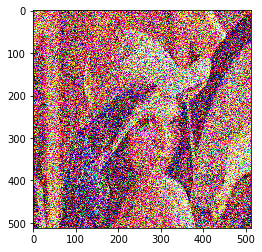

In [ ]:
img_array = np.asarray(image)
image2 = random_noise(img_array,mode = 'gaussian',var=0.20)
plt.imshow(image2)

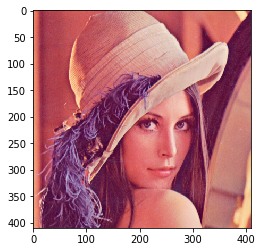

In [ ]:
central_cropped_image = tf.image.central_crop(image, 0.8)
with tf.Session() as sess:
    central_cropped_image_eval = central_cropped_image.eval()
    plt.imshow(central_cropped_image_eval)

In [ ]:
def hamming_dist(hash1,hash2):
    dist = 0
    for i in range(len(hash1)):
        if(hash1[i]!=hash2[i]):
            dist+=1
    return (dist/len(hash1))
        

In [ ]:
dist_rotated = []
c= 0

path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    hash1 = image_to_hash(image,512,512,new_cols)
    images = []
    c+=1
    print(c)
    for i in range(1,46):
        image2 = tf.contrib.image.rotate(image, i*(3.14/180), interpolation='BILINEAR')
        image3 = tf.contrib.image.rotate(image, (-1)*i*(3.14/180), interpolation='BILINEAR')
        with tf.Session() as sess:
            image2 = sess.run(image2)
            image3 = sess.run(image3)
        images.append(image2)
        images.append(image3)
        
    for img in images:
        attacked_hash = image_to_hash(img,512,512,new_cols)
        dist_rotated.append(hamming_dist(hash1,attacked_hash))
        

1
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

2
3
4
5
6
7
8
9
10
11
12
13
14


KeyboardInterrupt: ignored

(array([164., 173., 157.,  94., 152.,  56.,  63.,  70.,  58.,  34.,  29.,
         17.,  14.,  20.,  13.,   9.,   7.,  11.,   8.,   4.,   2.,   2.,
          1.,   5.,   6.,   1.,   3.,   0.,   4.,   4.]),
 array([0.        , 0.01548556, 0.03097113, 0.04645669, 0.06194226,
        0.07742782, 0.09291339, 0.10839895, 0.12388451, 0.13937008,
        0.15485564, 0.17034121, 0.18582677, 0.20131234, 0.2167979 ,
        0.23228346, 0.24776903, 0.26325459, 0.27874016, 0.29422572,
        0.30971129, 0.32519685, 0.34068241, 0.35616798, 0.37165354,
        0.38713911, 0.40262467, 0.41811024, 0.4335958 , 0.44908136,
        0.46456693]),
 <a list of 30 Patch objects>)

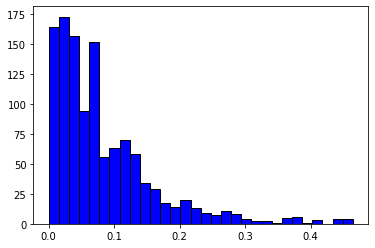

In [ ]:
plt.hist(dist_rotated, color = 'blue', edgecolor = 'black',
         bins = int(150/5))


In [ ]:
c = 0
dist_noises = []
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,512,512,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for var in range(5,21,1):
        image2 = random_noise(img_array,mode = 'gaussian',var=var/100)
        images.append(image2)
    
    for amount in range(1,11,1):
        image2 = salt_pepper(image,amount/10)
        images.append(image2)
    
    for crop in range(3,10,1):
        central_cropped_image = tf.image.central_crop(image,crop/10)
        with tf.Session() as sess:
            image2 = sess.run(central_cropped_image)
            images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,512,512,new_cols)
        dist_noises.append(hamming_dist(hash1,attacked_hash))
      



In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/' + file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,512,512,new_cols)
    images = []
    img_array = np.asarray(image)
    
    for var in range(5,21,1):
        image2 = random_noise(img_array,mode = 'gaussian',var=var/100)
        images.append(image2)
    
    for amount in range(1,11,1):
        image2 = salt_pepper(image,amount/10)
        images.append(image2)
    
    for crop in range(3,10,1):
        central_cropped_image = tf.image.central_crop(image,crop/10)
        with tf.Session() as sess:
            image2 = sess.run(central_cropped_image)
            images.append(image2)
            
            
    for img in images:
        attacked_hash = image_to_hash(img,512,512,new_cols)
        dist_noises.append(hamming_dist(hash1,attacked_hash))
      

In [ ]:
dist_noises

[0.09448818897637795,
 0.06299212598425197,
 0.047244094488188976,
 0.11023622047244094,
 0.07874015748031496,
 0.047244094488188976,
 0.07086614173228346,
 0.11023622047244094,
 0.13385826771653545,
 0.08661417322834646,
 0.08661417322834646,
 0.09448818897637795,
 0.12598425196850394,
 0.10236220472440945,
 0.10236220472440945,
 0.11811023622047244,
 0.07086614173228346,
 0.07086614173228346,
 0.09448818897637795,
 0.08661417322834646,
 0.14173228346456693,
 0.12598425196850394,
 0.11811023622047244,
 0.15748031496062992,
 0.15748031496062992,
 0.16535433070866143,
 0.3937007874015748,
 0.3464566929133858,
 0.3464566929133858,
 0.31496062992125984,
 0.2440944881889764,
 0.2047244094488189,
 0.14960629921259844,
 0.031496062992125984,
 0.031496062992125984,
 0.023622047244094488,
 0.03937007874015748,
 0.031496062992125984,
 0.03937007874015748,
 0.047244094488188976,
 0.03937007874015748,
 0.03937007874015748,
 0.03937007874015748,
 0.047244094488188976,
 0.047244094488188976,
 0.047

(array([174., 198., 275., 145., 126.,  89., 121.,  60.,  63.,  62.,  24.,
         24.,  12.,  17.,  10.,  14.,   6.,  12.,  14.,   8.,  10.,   5.,
          4.,   0.,   3.,   4.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   2.]),
 array([0.        , 0.01924759, 0.03849519, 0.05774278, 0.07699038,
        0.09623797, 0.11548556, 0.13473316, 0.15398075, 0.17322835,
        0.19247594, 0.21172353, 0.23097113, 0.25021872, 0.26946632,
        0.28871391, 0.3079615 , 0.3272091 , 0.34645669, 0.36570429,
        0.38495188, 0.40419948, 0.42344707, 0.44269466, 0.46194226,
        0.48118985, 0.50043745, 0.51968504, 0.53893263, 0.55818023,
        0.57742782, 0.59667542, 0.61592301, 0.6351706 , 0.6544182 ,
        0.67366579, 0.69291339]),
 <a list of 36 Patch objects>)

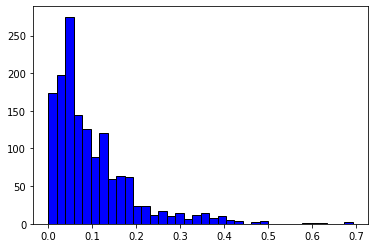

In [ ]:
plt.hist(dist_noises, color = 'blue', edgecolor = 'black',
         bins = int(180/5))


In [ ]:
dist_diff = []
c = 0
path = "/content/drive/My Drive/Colab Notebooks/ALL DB"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
    image = plt.imread(path + '/'+file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,512,512,new_cols)
    for files in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB"):
        if(files==file):
            continue
        image1 = plt.imread(path + '/'+files)
        hash2 = image_to_hash(image1,512,512,new_cols)
        dist_diff.append(hamming_dist(hash1,hash2))
        ##print(hamming_dist(hash1,hash2))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/ALL DB2"
for file in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB2"):
    image = plt.imread(path + '/'+file)
    c+=1
    print(c)
    hash1 = image_to_hash(image,512,512,new_cols)
    for files in os.listdir("/content/drive/My Drive/Colab Notebooks/ALL DB2"):
        if(files==file):
            continue
        image1 = plt.imread(path + '/'+files)
        hash2 = image_to_hash(image1,512,512,new_cols)
        dist_diff.append(hamming_dist(hash1,hash2))
        ##print(hamming_dist(hash1,hash2))

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [ ]:
dist_diff

[0.31496062992125984,
 0.14173228346456693,
 0.2047244094488189,
 0.14960629921259844,
 0.25984251968503935,
 0.2440944881889764,
 0.30708661417322836,
 0.4094488188976378,
 0.11811023622047244,
 0.28346456692913385,
 0.18110236220472442,
 0.2204724409448819,
 0.12598425196850394,
 0.3543307086614173,
 0.11023622047244094,
 0.30708661417322836,
 0.1732283464566929,
 0.2992125984251969,
 0.1889763779527559,
 0.23622047244094488,
 0.25984251968503935,
 0.11811023622047244,
 0.25196850393700787,
 0.3464566929133858,
 0.23622047244094488,
 0.25984251968503935,
 0.36220472440944884,
 0.31496062992125984,
 0.2047244094488189,
 0.14173228346456693,
 0.1968503937007874,
 0.2440944881889764,
 0.13385826771653545,
 0.5275590551181102,
 0.1889763779527559,
 0.2440944881889764,
 0.06299212598425197,
 0.4015748031496063,
 0.4409448818897638,
 0.2204724409448819,
 0.11811023622047244,
 0.31496062992125984,
 0.023622047244094488,
 0.14173228346456693,
 0.047244094488188976,
 0.12598425196850394,
 0.0

(array([32., 28., 56., 50., 70., 84., 42., 56., 68., 68., 68., 46., 40.,
        54., 46., 30., 36., 28., 32., 18., 22.,  6., 10.,  8.,  4., 12.,
         4.,  6.,  2.,  2.]),
 array([0.        , 0.02388451, 0.04776903, 0.07165354, 0.09553806,
        0.11942257, 0.14330709, 0.1671916 , 0.19107612, 0.21496063,
        0.23884514, 0.26272966, 0.28661417, 0.31049869, 0.3343832 ,
        0.35826772, 0.38215223, 0.40603675, 0.42992126, 0.45380577,
        0.47769029, 0.5015748 , 0.52545932, 0.54934383, 0.57322835,
        0.59711286, 0.62099738, 0.64488189, 0.6687664 , 0.69265092,
        0.71653543]),
 <a list of 30 Patch objects>)

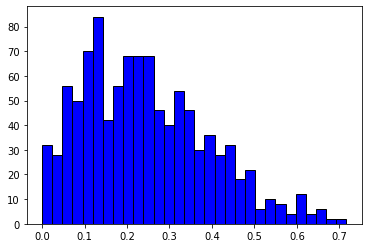

In [ ]:
plt.hist(dist_diff, color = 'blue', edgecolor = 'black',
         bins = int(150/5))
